**Exploring Correlation Between pH and Ammonia From METBUOY Data**
---

**OBJECTIVE:**

Perform data cleaning and explore the correlation between pH values and ammonium (mg/L) using the collected *METBUOY+* data deployed at Taal Lake, San Nicolas, Batangas, covering the period from October 4, 2024, to March 12, 2025.

## ACQURING RAW DATA

In [ ]:
import pandas as pd

url = "https://drive.google.com/uc?id=1nrsSXW553hV7rS9LynQ7uILNrWfNvNGI"
df = pd.read_csv(url).drop(columns=["WATER TURBIDITY (NTU)", "SPECIFIC CONDUCTIVITY (mS/cm)", "CHLOROPHYL (ug/L)"])

In [ ]:
df['DATE/TIME READ'] = pd.to_datetime(df['DATE/TIME READ'], errors="coerce")

start = "2024-10-04 0:01:08"
end = "2025-03-12 17:30:00"

df6m = df.loc[(df["DATE/TIME READ"] >= start) & (df["DATE/TIME READ"] <= end)].copy()

In [ ]:
num_cols = df6m.columns.drop("DATE/TIME READ")
df6m[num_cols] = df6m[num_cols].apply(pd.to_numeric, errors="coerce")

In [ ]:
df6m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7136 entries, 14743 to 21878
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   DATE/TIME READ                         7136 non-null   datetime64[ns]
 1   AIR TEMPERATURE (°C)                   7064 non-null   float64       
 2   AIR PRESSURE (hPa)                     7064 non-null   float64       
 3   WIND SPEED (kph)                       7065 non-null   float64       
 4   WIND ANGLE (Degrees C)                 7066 non-null   float64       
 5   WATER TEMPERATURE (Degrees C)          7105 non-null   float64       
 6   WATER SALINITY (PSU)                   7105 non-null   float64       
 7   TOTAL DISSOLVED SOLIDS (g/L)           7105 non-null   float64       
 8   RAW CONDUCTIVITY (uS/cm)               7105 non-null   float64       
 9   DISSOLVED OXYGEN (mg/L)                7105 non-null   float64 

## HANDLING MISSING VALUES

In [ ]:
df6m = df6m.dropna(subset=["DATE/TIME READ"]).sort_values("DATE/TIME READ").reset_index(drop=True)

In [ ]:
cols_needed = ["DATE/TIME READ", "PH VALUE (pH)", "AMMONIUM (mg/L)"]

ph_ammo = df6m[[c for c in cols_needed if c in df6m.columns]].copy()
ph_ammo.head()

,DATE/TIME READ,PH VALUE (pH),AMMONIUM (mg/L)
0,2024-10-04 00:01:08,9.49,3.65
1,2024-10-04 00:30:57,9.47,3.57
2,2024-10-04 01:00:59,9.47,3.48
3,2024-10-04 01:31:01,9.46,3.51
4,2024-10-04 02:01:01,9.45,3.32


In [ ]:
# create a "day only" column which will be set as index
ph_ammo["DAY"] = ph_ammo["DATE/TIME READ"].dt.date

# get the total count of rows for each day
total_rows_df = ph_ammo.groupby("DAY")[["PH VALUE (pH)", "AMMONIUM (mg/L)"]].size().rename("total_rows")

# get the total count of missing values in pH column for each day
nan_ph_df = ph_ammo.groupby("DAY")["PH VALUE (pH)"].apply(lambda s: s.isna().sum()).rename("nan_ph")

# get the total count of missing values in Ammonium column for each day
nan_ammo_df = ph_ammo.groupby("DAY")["AMMONIUM (mg/L)"].apply(lambda s: s.isna().sum()).rename("nan_ammo")

# create a dataframe combining all columns and bring the date back
audit = pd.concat([total_rows_df, nan_ph_df, nan_ammo_df], axis=1).reset_index()
audit.head()

,DAY,total_rows,nan_ph,nan_ammo
0,2024-10-04,64,11,2
1,2024-10-05,48,0,0
2,2024-10-06,48,0,0
3,2024-10-07,48,0,0
4,2024-10-08,48,0,0


In [ ]:
audit["nan_ph_%"] = (audit["nan_ph"] / audit["total_rows"]).round(2)
audit["nan_ammo_%"] = (audit["nan_ammo"] / audit["total_rows"]).round(2)
audit.head()

,DAY,total_rows,nan_ph,nan_ammo,nan_ph_%,nan_ammo_%
0,2024-10-04,64,11,2,0.17,0.03
1,2024-10-05,48,0,0,0.00,0.00
2,2024-10-06,48,0,0,0.00,0.00
3,2024-10-07,48,0,0,0.00,0.00
4,2024-10-08,48,0,0,0.00,0.00


In [ ]:
audit["keep_day"] = (audit["nan_ph_%"] < 0.20) & (audit["nan_ammo_%"] < 0.20)
audit.head()

,DAY,total_rows,nan_ph,nan_ammo,nan_ph_%,nan_ammo_%,keep_day
0,2024-10-04,64,11,2,0.17,0.03,True
1,2024-10-05,48,0,0,0.00,0.00,True
2,2024-10-06,48,0,0,0.00,0.00,True
3,2024-10-07,48,0,0,0.00,0.00,True
4,2024-10-08,48,0,0,0.00,0.00,True


In [ ]:
audit.loc[audit["keep_day"] == False, audit.columns]

,DAY,total_rows,nan_ph,nan_ammo,nan_ph_%,nan_ammo_%,keep_day
20,2024-10-24,48,0,43,0.00,0.90,False
82,2024-12-25,38,10,10,0.26,0.26,False


In [ ]:
kept_days = set(audit.loc[audit["keep_day"], "DAY"])

In [ ]:
df_keep = ph_ammo[ph_ammo["DAY"].isin(kept_days)].copy()
df_keep.head()

,DATE/TIME READ,PH VALUE (pH),AMMONIUM (mg/L),DAY
0,2024-10-04 00:01:08,9.49,3.65,2024-10-04
1,2024-10-04 00:30:57,9.47,3.57,2024-10-04
2,2024-10-04 01:00:59,9.47,3.48,2024-10-04
3,2024-10-04 01:31:01,9.46,3.51,2024-10-04
4,2024-10-04 02:01:01,9.45,3.32,2024-10-04


In [ ]:
df_drop = ph_ammo[~ph_ammo["DAY"].isin(kept_days)].copy()
df_drop

,DATE/TIME READ,PH VALUE (pH),AMMONIUM (mg/L),DAY
975,2024-10-24 00:01:03,8.48,2.23,2024-10-24
976,2024-10-24 00:30:45,8.47,2.24,2024-10-24
977,2024-10-24 01:00:48,8.44,2.25,2024-10-24
978,2024-10-24 01:01:00,8.40,NaN,2024-10-24
979,2024-10-24 02:00:50,8.36,NaN,2024-10-24
...,...,...,...,...
3975,2024-12-25 18:00:49,8.88,1.28,2024-12-25
3976,2024-12-25 19:00:49,8.88,1.28,2024-12-25
3977,2024-12-25 19:30:51,8.88,1.29,2024-12-25
3978,2024-12-25 20:30:50,8.87,1.29,2024-12-25


In [ ]:
df_keep = df_keep.set_index("DATE/TIME READ")

In [ ]:
# function for interpolation
def day_interpolation(g: pd.DataFrame) -> pd.DataFrame:
  g[["PH VALUE (pH)", "AMMONIUM (mg/L)"]] = g[["PH VALUE (pH)", "AMMONIUM (mg/L)"]].interpolate(method="time", limit_direction="both")
  return g

# applying the function to each day
df_keep = df_keep.groupby("DAY", group_keys=False).apply(day_interpolation)

# organizing the columns
df_keep = df_keep[["DAY", "PH VALUE (pH)", "AMMONIUM (mg/L)"]]

/tmp/ipython-input-3177834123.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_keep = df_keep.groupby("DAY", group_keys=False).apply(day_interpolation)


In [ ]:
df_keep.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7050 entries, 2024-10-04 00:01:08 to 2025-03-12 17:30:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DAY              7050 non-null   object 
 1   PH VALUE (pH)    7050 non-null   float64
 2   AMMONIUM (mg/L)  7050 non-null   float64
dtypes: float64(2), object(1)
memory usage: 220.3+ KB


In [ ]:
# save then drop DAY column
df_day = df_keep[["DAY"]].copy()
df_keep = df_keep.drop(columns="DAY")

Use this code to bring the DAY column back to the df_keep DataFrame:
`df_keep = pd.concat([df_keep, df_day], axis=1)`

## HANDLING OUTLIERS

#### Handling Outliers in PH VALUE (pH)

In [ ]:
Q1_ph = df_keep['PH VALUE (pH)'].quantile(0.25)
Q3_ph = df_keep['PH VALUE (pH)'].quantile(0.75)
IQR_ph = Q3_ph - Q1_ph
min_ph = Q1_ph - 1.5 * IQR_ph
max_ph = Q3_ph + 1.5 * IQR_ph
outliers_ph = df_keep[(df_keep['PH VALUE (pH)'] < min_ph) | (df_keep['PH VALUE (pH)'] > max_ph)]

In [ ]:
print("Number of outliers in PH VALUE (pH):", outliers_ph.shape[0])

Number of outliers in PH VALUE (pH): 21


In [ ]:
outliers_ph['PH VALUE (pH)'].head(21)

,PH VALUE (pH)
971,8.53
972,8.51
973,8.50
974,8.48
975,8.33
976,8.34
977,8.36
978,8.39
979,8.41
980,8.43


Outliers in PH VALUE (pH) are realistic, not faulty sensor errors, hence they will be kept.

#### Handling Outliers in AMMONIUM (mg/L)

In [ ]:
Q1 = df_keep['AMMONIUM (mg/L)'].quantile(0.25)
Q3 = df_keep['AMMONIUM (mg/L)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_keep[(df_keep['AMMONIUM (mg/L)'] < lower_bound) | (df_keep['AMMONIUM (mg/L)'] > upper_bound)]

In [ ]:
print("Number of outliers in AMMONIUM (mg/L):", outliers.shape[0])

Number of outliers in AMMONIUM (mg/L): 20


In [ ]:
outliers['AMMONIUM (mg/L)'].head(21)

,AMMONIUM (mg/L)
19,119.089021
20,183.500000
21,183.300000
24,187.250000
25,189.050000
26,188.210000
27,188.840000
28,188.840000
29,185.060000
33,186.410000


Outliers in AMMONIUM (mg/L) are clearly sensor errors, hence they will be treated as NaN and interpolated together with the 0.0 values.

In [ ]:
# save data with outliers and 0.0 values for comparison
before = df_keep['AMMONIUM (mg/L)'].copy()

In [ ]:
import numpy as np

In [ ]:
# outliers to NaN
outliers_bool = (df_keep['AMMONIUM (mg/L)'] < lower_bound) | (df_keep['AMMONIUM (mg/L)'] > upper_bound)
df_keep.loc[outliers_bool, 'AMMONIUM (mg/L)'] = np.nan

In [ ]:
# 0.0 to NaN
df_keep['AMMONIUM (mg/L)'] = df_keep['AMMONIUM (mg/L)'].replace(0, np.nan)

In [ ]:
# interpolation
df_keep = df_keep.set_index('DATE/TIME READ')
df_keep['AMMONIUM (mg/L)'] = df_keep['AMMONIUM (mg/L)'].interpolate(
    method='time',
    limit_direction='both'   # fills edges too; remove if you want edge NaNs preserved
)
df_keep = df_keep.reset_index()

In [ ]:
# for comparison
after = df_keep['AMMONIUM (mg/L)']
changed_mask = ~before.eq(after)

changes = df_keep.loc[changed_mask, ['DATE/TIME READ']].copy()
changes['before'] = before[changed_mask].values
changes['after']  = after[changed_mask].values

print(changes)

          DATE/TIME READ      before     after
19   2024-10-04 08:37:06  119.089021  3.062835
20   2024-10-04 08:40:12  183.500000  3.053305
21   2024-10-04 08:42:13  183.300000  3.047105
24   2024-10-04 09:06:08  187.250000  2.992238
25   2024-10-04 09:06:54  189.050000  2.991079
26   2024-10-04 09:12:03  188.210000  2.983291
27   2024-10-04 09:15:31  188.840000  2.978049
28   2024-10-04 09:17:58  188.840000  2.974345
29   2024-10-04 09:32:40  185.060000  2.952117
33   2024-10-04 09:43:11  186.410000  2.960000
3811 2024-12-23 06:30:49  345.100000  1.269445
3812 2024-12-23 07:00:50  346.100000  1.268889
3813 2024-12-23 07:30:49    0.000000  1.268334
3814 2024-12-23 08:00:49  346.100000  1.267778
3815 2024-12-23 08:30:48    0.000000  1.267223
3816 2024-12-23 09:00:50    0.000000  1.266667
3817 2024-12-23 09:30:51  346.100000  1.266111
3818 2024-12-23 10:00:51    0.000000  1.265556
3819 2024-12-23 10:30:50  341.700000  1.265000
3820 2024-12-23 11:00:52  341.400000  1.264444
3821 2024-12-

In [ ]:
print("Before:")
print(before.describe())

print("\nAfter:")
print(after.describe())

Before:
count    7050.000000
mean        2.182555
std        14.506720
min         0.000000
25%         0.800000
50%         1.470000
75%         2.070000
max       346.100000
Name: AMMONIUM (mg/L), dtype: float64

After:
count    7050.000000
mean        1.450319
std         0.680177
min         0.360000
25%         0.800000
50%         1.460000
75%         2.070000
max         3.650000
Name: AMMONIUM (mg/L), dtype: float64


In [ ]:
df_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE/TIME READ   7050 non-null   datetime64[ns]
 1   PH VALUE (pH)    7050 non-null   float64       
 2   AMMONIUM (mg/L)  7050 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 165.4 KB


<Axes: xlabel='DATE/TIME READ'>

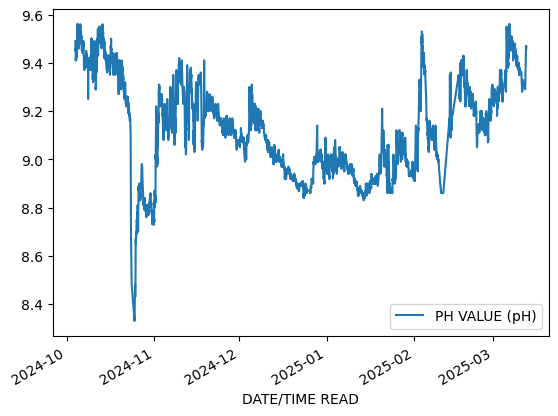

In [ ]:
df_keep.plot(x="DATE/TIME READ", y="PH VALUE (pH)")

<Axes: xlabel='DATE/TIME READ'>

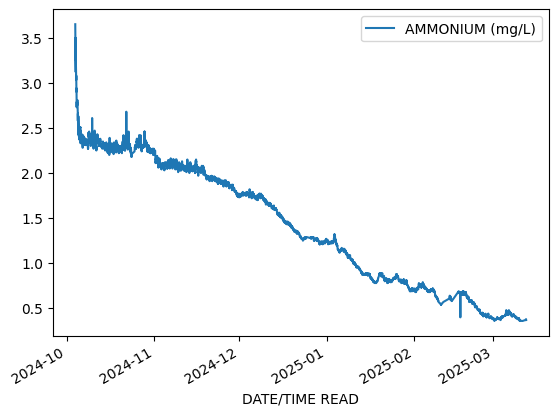

In [ ]:
df_keep.plot(x="DATE/TIME READ", y="AMMONIUM (mg/L)")

## DATA TRANSFORMATION 1 (LONG FORMAT3)


#### Build a grid with 30-minute intervals

In [ ]:
df_keep.head()

,DATE/TIME READ,PH VALUE (pH),AMMONIUM (mg/L)
0,2024-10-04 00:01:08,9.49,3.65
1,2024-10-04 00:30:57,9.47,3.57
2,2024-10-04 01:00:59,9.47,3.48
3,2024-10-04 01:31:01,9.46,3.51
4,2024-10-04 02:01:01,9.45,3.32


In [ ]:
col_datetime = "DATE/TIME READ"
col_ph   = "PH VALUE (pH)"
col_ammo  = "AMMONIUM (mg/L)"
value_cols = [col_ph, col_ammo]

In [ ]:
df_keep = df_keep.set_index(col_datetime)

In [ ]:
df_keep

,PH VALUE (pH),AMMONIUM (mg/L)
DATE/TIME READ,,
2024-10-04 00:01:08,9.49,3.65
2024-10-04 00:30:57,9.47,3.57
2024-10-04 01:00:59,9.47,3.48
2024-10-04 01:31:01,9.46,3.51
2024-10-04 02:01:01,9.45,3.32
...,...,...
2025-03-12 09:30:00,9.29,0.37
2025-03-12 16:00:00,9.47,0.38
2025-03-12 16:30:00,9.46,0.38


In [ ]:
# build full 30-min grid from first day 00:00 to last day 23:30
first = df_keep.index.normalize().min()
last = df_keep.index.normalize().max()
full_index = pd.date_range(start=first,
                           end = last + pd.Timedelta(hours=23, minutes=30),
                           freq="30min")

In [ ]:
full_index

DatetimeIndex(['2024-10-04 00:00:00', '2024-10-04 00:30:00',
               '2024-10-04 01:00:00', '2024-10-04 01:30:00',
               '2024-10-04 02:00:00', '2024-10-04 02:30:00',
               '2024-10-04 03:00:00', '2024-10-04 03:30:00',
               '2024-10-04 04:00:00', '2024-10-04 04:30:00',
               ...
               '2025-03-12 19:00:00', '2025-03-12 19:30:00',
               '2025-03-12 20:00:00', '2025-03-12 20:30:00',
               '2025-03-12 21:00:00', '2025-03-12 21:30:00',
               '2025-03-12 22:00:00', '2025-03-12 22:30:00',
               '2025-03-12 23:00:00', '2025-03-12 23:30:00'],
              dtype='datetime64[ns]', length=7680, freq='30min')

In [ ]:
# helpers to map to the custom index later
unique_days = full_index.normalize().unique()
day_count  = {d: i + 1 for i, d in enumerate(unique_days)}

In [ ]:
unique_days

DatetimeIndex(['2024-10-04', '2024-10-05', '2024-10-06', '2024-10-07',
               '2024-10-08', '2024-10-09', '2024-10-10', '2024-10-11',
               '2024-10-12', '2024-10-13',
               ...
               '2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06',
               '2025-03-07', '2025-03-08', '2025-03-09', '2025-03-10',
               '2025-03-11', '2025-03-12'],
              dtype='datetime64[ns]', length=160, freq=None)

In [ ]:
print(day_count)

{Timestamp('2024-10-04 00:00:00'): 1, Timestamp('2024-10-05 00:00:00'): 2, Timestamp('2024-10-06 00:00:00'): 3, Timestamp('2024-10-07 00:00:00'): 4, Timestamp('2024-10-08 00:00:00'): 5, Timestamp('2024-10-09 00:00:00'): 6, Timestamp('2024-10-10 00:00:00'): 7, Timestamp('2024-10-11 00:00:00'): 8, Timestamp('2024-10-12 00:00:00'): 9, Timestamp('2024-10-13 00:00:00'): 10, Timestamp('2024-10-14 00:00:00'): 11, Timestamp('2024-10-15 00:00:00'): 12, Timestamp('2024-10-16 00:00:00'): 13, Timestamp('2024-10-17 00:00:00'): 14, Timestamp('2024-10-18 00:00:00'): 15, Timestamp('2024-10-19 00:00:00'): 16, Timestamp('2024-10-20 00:00:00'): 17, Timestamp('2024-10-21 00:00:00'): 18, Timestamp('2024-10-22 00:00:00'): 19, Timestamp('2024-10-23 00:00:00'): 20, Timestamp('2024-10-24 00:00:00'): 21, Timestamp('2024-10-25 00:00:00'): 22, Timestamp('2024-10-26 00:00:00'): 23, Timestamp('2024-10-27 00:00:00'): 24, Timestamp('2024-10-28 00:00:00'): 25, Timestamp('2024-10-29 00:00:00'): 26, Timestamp('2024-10-3

#### Create functions for line-fitting and moving-average fillers

In [ ]:
import builtins as bi

In [ ]:
def linefit_then_predict(day_df : pd.DataFrame,
                         time_grid: pd.DatetimeIndex,
                         col : str,
                         k : int = 6) -> pd.Series:
    """
    This creates a straight line y = a + b * t within a single day using the last 6 (k) valid readings of that day,
    then predicts the value at each of the 48 30-min timestamps (time_grid) for that day.
    """
    # keep only rows where the chosen column has a number (no NaN)
    valid_day = day_df[[col]].dropna()

    # if we have fewer than 2 points, we can't fit a line → return all NaN
    if valid_day.shape[0] < 2:
      return pd.Series(np.nan, index=time_grid, dtype=float)

    # use **only the most recent k points** of the day (e.g., last 6 readings)
    take = bi.min(k, len(valid_day))
    valid_day = valid_day.iloc[-take:]

    # we measure time "minutes since midnight" of THIS day
    t0 = time_grid[0].normalize() # e.g., 2024-10-04 00:00

    # x = minutes since midnight for each raw point of this day
    td_raw = (valid_day.index - t0) # TimedeltaIndex
    x = (td_raw / np.timedelta64(1, 'm')).to_numpy() # e.g., [1.0, 37.0, ...]

    # y = the actual sensor values for those points
    y = valid_day[col].to_numpy(dtype=float)

    # do OLS wth guard against degenerate cases.
    x_center = x - x.mean() # center x for better numerics
    denom = float(np.dot(x_center, x_center)) # sum of squares
    if denom == 0.0:
      # if all x are the same → slope 0, intercept = mean(y)
      a = float(np.nanmean(y)); b = 0.0
    else:
      # slope b = cov(x,y)/var(x); intercept a = mean(y) - b*mean(x)
      b = float(np.dot(x_center, (y - y.mean())) / denom)
      a = float(y.mean() - b * x.mean())

    # gx = minutes since midnight for the **grid** (the 48 target timestamps)
    td_grid = (time_grid - t0)
    gx = (td_grid / np.timedelta64(1, 'm')).to_numpy(dtype=float)

    # predicted values = a + b * minutes
    preds = a + b * gx
    return pd.Series(preds, index=time_grid, dtype=float)

In [ ]:
def moving_average_with_linefit(day_df: pd.DataFrame,
                                time_grid: pd.DatetimeIndex,
                                col: str,
                                window_minutes: int = 90,
                                k_linefit: int = 6) -> tuple[pd.Series, pd.Series]:
    """
    For each 30-min timestamp in this **day**:
      1) try a moving-average: average points within ±90
      2) if NONE in that window → use line-fit prediction (above)
    Returns:
      - out_vals: values for all 48 slots of that day
      - did_linefit: True where we had to estimate (line-fit), False if from window mean
    """
    # set up empty containers aligned to the day's 48 timestamps
    out_vals = pd.Series(index=time_grid, dtype=float)
    did_linefit = pd.Series(index=time_grid, dtype=bool)

    # precompute the day's line-fit predictions (we might use them as fallback)
    linefit_preds = linefit_then_predict(day_df, time_grid, col, k=k_linefit)

    # quick access handles to the raw times/values for the chosen column
    raw_times = day_df.index
    raw_values = day_df[col]
    ninety = pd.Timedelta(minutes=window_minutes) # ±15 minutes

    # loop over the 48 timestamps in this day (00:00, 00:30, ... 23:30)
    for mid in time_grid:
      low, high = mid - ninety, mid + ninety # the window around 't' (-90...mid...+90) ->
      mask = (raw_times >= low) & (raw_times <= high) # which raw rows lie in that window?

      if mask.any():
        #  if we have at least one raw reading in the window -> take the mean
        out_vals.loc[mid] = float(raw_values[mask].mean()) # this came from real data near t
        did_linefit[mid] = False # we estimated this one
      else:
        out_vals.loc[mid] = float(linefit_preds.loc[mid])
        did_linefit.loc[mid] = True # estimated via line fit

    return out_vals, did_linefit

In [ ]:
format1 = pd.DataFrame(index=full_index)

In [ ]:
format1

""
2024-10-04 00:00:00
2024-10-04 00:30:00
2024-10-04 01:00:00
2024-10-04 01:30:00
2024-10-04 02:00:00
...
2025-03-12 21:30:00
2025-03-12 22:00:00
2025-03-12 22:30:00
2025-03-12 23:00:00


In [ ]:
flag_cols = [] # we will store the per-variable "estimated flags" here

for col in value_cols: # do pH first, then ammonium
  series_list = [] # will collect the 48-slot values per day
  flag_list = [] # and the corresponding True/False flags per day

  # go day by day (group by calendar date). This prevents cross-day leakage.
  for day, day_slice in df_keep.groupby(df_keep.index.normalize()):
    # the 48 timestamps for this specific day from our big grid
    day_grid = format1.loc[format1.index.normalize() == day].index

    # the raw readings for THIS day and THIS column (drop NaNs)
    day_data = day_slice[[col]].dropna()

    # use the hybrid filler: window mean if any points near the slot, otherwise fallback to the day's line-fit prediction
    vals, est_flag = moving_average_with_linefit(
        day_df = day_data,
        time_grid = day_grid,
        col = col,
        window_minutes = 90,
        k_linefit = 6
    )

    # keep the day’s 48 values and flags
    series_list.append(vals)
    flag_list.append(est_flag)

  # after looping all days, stitch the daily pieces into one big column, round to 2 decimals, and store into the output DataFrame
  format1[col] = pd.concat(series_list).round(2)

  # also save the flags for this variable (True where we estimated)
  flag_cols.append(pd.concat(flag_list))

In [ ]:
if flag_cols:
  interporlated_any = flag_cols[0].copy()
  for f in flag_cols[1:]:
    interporlated_any = interporlated_any | f
  format1["INTERPOLATED"] = interporlated_any.fillna(True) # treat missing lag as True
else:
  format1["INTERPOLATED"] = True

#### Create DAY_HHMM index and check if there are still missing values

In [ ]:
format1["DAY_NUM"] = format1.index.normalize().map(day_count)
format1["HH_MM"]   = format1.index.strftime("%H%M")
format1["DAY_HHMM"] = format1["DAY_NUM"].astype(str) + "-" + format1["HH_MM"]

format1 = format1.drop(columns=["DAY_NUM", "HH_MM"])

In [ ]:
format1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7680 entries, 2024-10-04 00:00:00 to 2025-03-12 23:30:00
Freq: 30min
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PH VALUE (pH)    7488 non-null   float64
 1   AMMONIUM (mg/L)  7488 non-null   float64
 2   INTERPOLATED     7488 non-null   object 
 3   DAY_HHMM         7680 non-null   object 
dtypes: float64(2), object(2)
memory usage: 300.0+ KB


In [ ]:
format1 = format1.set_index("DAY_HHMM")

Missing values are still present. Export as csv and check what days are empty using the code below:
```
format1.to_csv('format1_with_nan.csv')
```
After checking, identify the days that are empty and use **Neighbor-day bridge** to get the average values of the previous day and next day and use them to fill the empty day.


In [ ]:
# Neighbor-day Bridge

empty_days = [21, 83, 132, 135]

# helpers to parse the composite index "DAY_HHMM"
str_time = format1.index.str[-4:]                               # last 4 chars → "0000",...,"0030"
day_num = format1.index.str.split("-", n=1).str[0].astype(int)  # str[0] selects day number

# function to get a mask (True/False array) for all rows of a given day
def rows_for_day(d):
  return day_num == d

# loop through each missing day we want to fix
for d in empty_days:
  mask_d = rows_for_day(d) # rows of the empty day
  mask_prev = rows_for_day(d - 1) # rows of the previous day
  mask_next = rows_for_day(d + 1) # rows of the next day

  # extract the "HHMM" slot labels for this day and its neighbors
  slots_d = str_time[mask_d]       # e.g. ["0000",...,"2330"] for day d
  slots_prev = str_time[mask_prev] # slots of day d-1
  slots_next = str_time[mask_next] # slots of day d+1

  # fill values column by column (PH and Ammonium)
  for col in value_cols:
    prev_values = pd.Series(format1.loc[mask_prev, col].values, index=slots_prev) # get the values of previous day
    next_values = pd.Series(format1.loc[mask_next, col].values, index=slots_next) # get the values of the next day
    average_values = (prev_values + next_values) / 2.0                            # average the previous and next day values
    format1.loc[mask_d, col] = average_values.loc[slots_d].values                 # put the averaged values into the missing day

  # mark the entire day as interpolated
  format1.loc[mask_d, "INTERPOLATED"] = True

format1[value_cols] = format1[value_cols].round(2)




In [ ]:
format1 = format1.reset_index()
format1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7680 entries, 0 to 7679
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DAY_HHMM         7680 non-null   object 
 1   PH VALUE (pH)    7680 non-null   float64
 2   AMMONIUM (mg/L)  7680 non-null   float64
 3   INTERPOLATED     7680 non-null   object 
dtypes: float64(2), object(2)
memory usage: 240.1+ KB


#### Plot and correlate format 1

<Axes: xlabel='DAY_HHMM'>

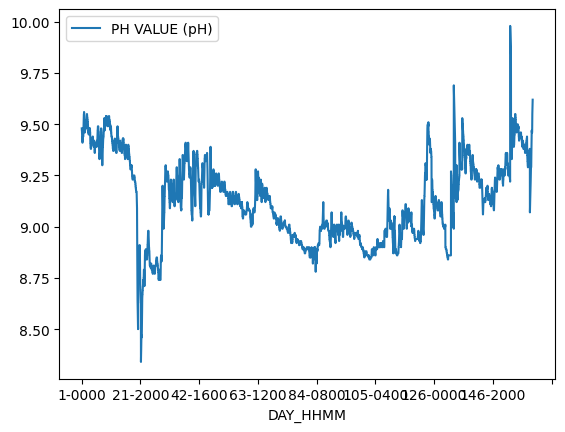

In [ ]:
format1.plot(x="DAY_HHMM", y="PH VALUE (pH)")

<Axes: xlabel='AMMONIUM (mg/L)', ylabel='PH VALUE (pH)'>

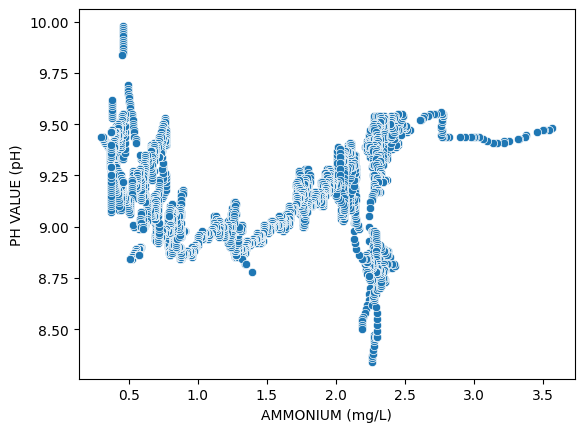

In [ ]:
import seaborn as sns

sns.scatterplot(data=format1, x="AMMONIUM (mg/L)", y="PH VALUE (pH)")

In [ ]:
format1

,DAY_HHMM,PH VALUE (pH),AMMONIUM (mg/L),INTERPOLATED
0,1-0000,9.48,3.57,False
1,1-0030,9.47,3.55,False
2,1-0100,9.47,3.51,False
3,1-0130,9.47,3.50,False
4,1-0200,9.46,3.46,False
...,...,...,...,...
7675,160-2130,9.57,0.38,True
7676,160-2200,9.59,0.38,True
7677,160-2230,9.60,0.38,True
7678,160-2300,9.61,0.38,True


In [ ]:
from sklearn.linear_model import LinearRegression

X = format1["AMMONIUM (mg/L)"].values.reshape(-1, 1)
y = format1["PH VALUE (pH)"].values
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
print(f"  R² = {r2:.4f}")

  R² = 0.0120


In [ ]:
format1 = format1.set_index("DAY_HHMM")

In [ ]:
corr = format1.corr(method="spearman")["AMMONIUM (mg/L)"]["PH VALUE (pH)"]
print(f"Correlation = {corr:.4f}")

Correlation = 0.0897


#### Lineplots

In [ ]:
start_date = pd.Timestamp("2024-10-04")

idx = format1.index.astype(str)                          # "DAY_HHMM"
day  = idx.str.split("-", n=1).str[0].astype(int)        # 1,2,...,160
hhmm = idx.str[-4:]                                      # "0000","0030",...

hours   = hhmm.str[:2].astype(int)
minutes = hhmm.str[2:].astype(int)

orig_index = (start_date
            + pd.to_timedelta(day - 1, unit="D")
            + pd.to_timedelta(hours,   unit="h")
            + pd.to_timedelta(minutes, unit="m"))

format1_dt = format1.copy()
format1_dt.index = pd.DatetimeIndex(orig_index, name="DATE/TIME")

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

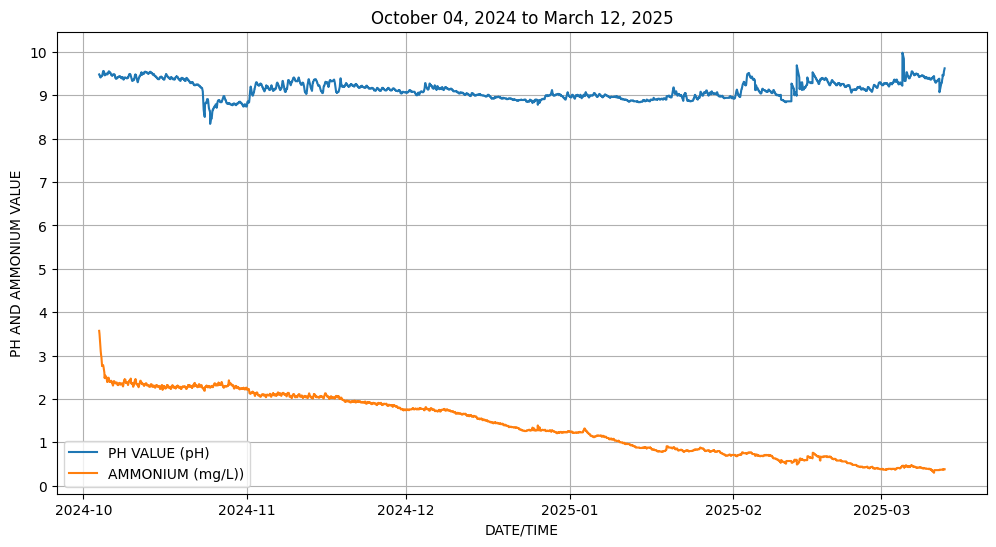

In [ ]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=format1_dt, x="DATE/TIME", y="PH VALUE (pH)", label="PH VALUE (pH)")
sns.lineplot(data=format1_dt, x="DATE/TIME", y="AMMONIUM (mg/L)", label="AMMONIUM (mg/L)")

plt.grid(True)
plt.yticks(np.arange(0, 11, 1))
plt.ylabel("PH AND AMMONIUM VALUE")
plt.title("October 04, 2024 to March 12, 2025")
plt.show()

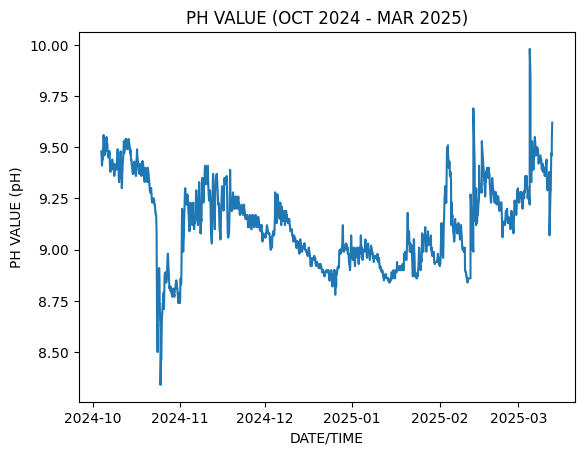

In [ ]:
sns.lineplot(data=format1_dt, x="DATE/TIME", y="PH VALUE (pH)")
plt.title("PH VALUE (OCT 2024 - MAR 2025)")
plt.show()

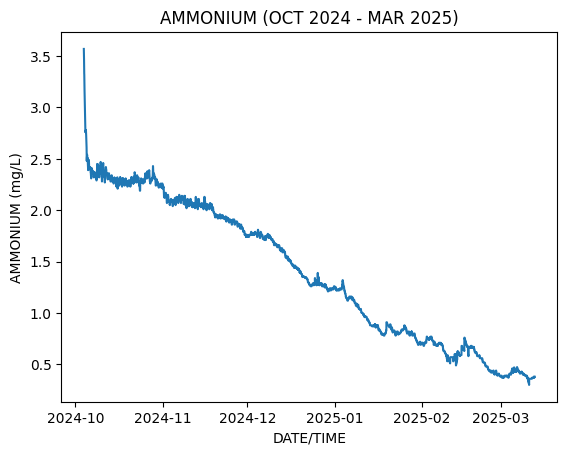

In [ ]:
sns.lineplot(data=format1_dt, x="DATE/TIME", y="AMMONIUM (mg/L)")
plt.title("AMMONIUM (OCT 2024 - MAR 2025)")
plt.show()

## LAGGED DATA AND CORRELATIONAL ANALYSIS

#### Create the lagged dataframe

In [ ]:
# format1 = format1.set_index("DAY_HHMM")

In [ ]:
lag_mins = [30, 60, 90, 120, 150, 180]

lagged = pd.DataFrame(index=format1.index)

lagged["PH"] = format1['PH VALUE (pH)']
for i, m in enumerate(lag_mins, start=1):
  lagged[f"PH_{m}"] = format1['PH VALUE (pH)'].shift(i)

lagged["AMM"] = format1['AMMONIUM (mg/L)']
for i, m in enumerate(lag_mins, start=1):
  lagged[f"AMM_{m}"] = format1['AMMONIUM (mg/L)'].shift(i)

In [ ]:
lagged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7680 entries, 1-0000 to 160-2330
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PH       7680 non-null   float64
 1   PH_30    7679 non-null   float64
 2   PH_60    7678 non-null   float64
 3   PH_90    7677 non-null   float64
 4   PH_120   7676 non-null   float64
 5   PH_150   7675 non-null   float64
 6   PH_180   7674 non-null   float64
 7   AMM      7680 non-null   float64
 8   AMM_30   7679 non-null   float64
 9   AMM_60   7678 non-null   float64
 10  AMM_90   7677 non-null   float64
 11  AMM_120  7676 non-null   float64
 12  AMM_150  7675 non-null   float64
 13  AMM_180  7674 non-null   float64
dtypes: float64(14)
memory usage: 900.0+ KB


In [ ]:
lagged.head(7)

,PH,PH_30,PH_60,PH_90,PH_120,PH_150,PH_180,AMM,AMM_30,AMM_60,AMM_90,AMM_120,AMM_150,AMM_180
DAY_HHMM,,,,,,,,,,,,,,
1-0000,9.48,NaN,NaN,NaN,NaN,NaN,NaN,3.57,NaN,NaN,NaN,NaN,NaN,NaN
1-0030,9.47,9.48,NaN,NaN,NaN,NaN,NaN,3.55,3.57,NaN,NaN,NaN,NaN,NaN
1-0100,9.47,9.47,9.48,NaN,NaN,NaN,NaN,3.51,3.55,3.57,NaN,NaN,NaN,NaN
1-0130,9.47,9.47,9.47,9.48,NaN,NaN,NaN,3.50,3.51,3.55,3.57,NaN,NaN,NaN
1-0200,9.46,9.47,9.47,9.47,9.48,NaN,NaN,3.46,3.50,3.51,3.55,3.57,NaN,NaN
1-0230,9.45,9.46,9.47,9.47,9.47,9.48,NaN,3.38,3.46,3.50,3.51,3.55,3.57,NaN
1-0300,9.44,9.45,9.46,9.47,9.47,9.47,9.48,3.37,3.38,3.46,3.50,3.51,3.55,3.57


In [ ]:
# create copies with NaN for comparison later
amm_before = lagged["AMM_180"].copy()
ph_before  = lagged["PH_180"].copy()

#### Handle the missing values in the lagged dataframe using Line-Fitting

In [ ]:
lag_cols = ["PH","PH_30","PH_60","PH_90","PH_120","PH_150","PH_180",
            "AMM","AMM_30","AMM_60","AMM_90","AMM_120","AMM_150","AMM_180"]

def fill_leading_with_linefit(s: pd.Series, k: int = 6) -> pd.Series:
    """Fill leading NaNs using a straight line fit from the first k valid points."""
    first_valid = s.first_valid_index()
    if first_valid is None:
        return s  # nothing to fit
    first_pos = s.index.get_loc(first_valid)
    if first_pos == 0:
        return s  # no leading NaNs

    # use first k valid points
    valid_vals = s.dropna().iloc[:k]
    x = np.arange(len(valid_vals))                # 0,1,2,...
    y = valid_vals.values.astype(float)

    # simple linear regression (least squares)
    coeffs = np.polyfit(x, y, deg=1)
    a, b = coeffs[1], coeffs[0]                  # y = a + b*x

    # predict backwards for missing positions
    n_missing = first_pos
    x_missing = -np.arange(n_missing, 0, -1)     # negative steps before 0
    preds = a + b * x_missing

    # fill them
    s.iloc[:first_pos] = preds
    return s

# apply to all lagged columns
lagged[lag_cols] = lagged[lag_cols].apply(lambda s: fill_leading_with_linefit(s, k=6))
lagged[lag_cols] = lagged[lag_cols].round(2)

In [ ]:
lagged.head(7)

,PH,PH_30,PH_60,PH_90,PH_120,PH_150,PH_180,AMM,AMM_30,AMM_60,AMM_90,AMM_120,AMM_150,AMM_180
DAY_HHMM,,,,,,,,,,,,,,
1-0000,9.48,9.48,9.49,9.49,9.50,9.51,9.51,3.57,3.62,3.65,3.69,3.72,3.76,3.79
1-0030,9.47,9.48,9.48,9.49,9.49,9.50,9.51,3.55,3.57,3.62,3.65,3.69,3.72,3.76
1-0100,9.47,9.47,9.48,9.48,9.49,9.49,9.50,3.51,3.55,3.57,3.62,3.65,3.69,3.72
1-0130,9.47,9.47,9.47,9.48,9.48,9.49,9.49,3.50,3.51,3.55,3.57,3.62,3.65,3.69
1-0200,9.46,9.47,9.47,9.47,9.48,9.48,9.49,3.46,3.50,3.51,3.55,3.57,3.62,3.65
1-0230,9.45,9.46,9.47,9.47,9.47,9.48,9.48,3.38,3.46,3.50,3.51,3.55,3.57,3.62
1-0300,9.44,9.45,9.46,9.47,9.47,9.47,9.48,3.37,3.38,3.46,3.50,3.51,3.55,3.57


In [ ]:
import matplotlib.pyplot as plt

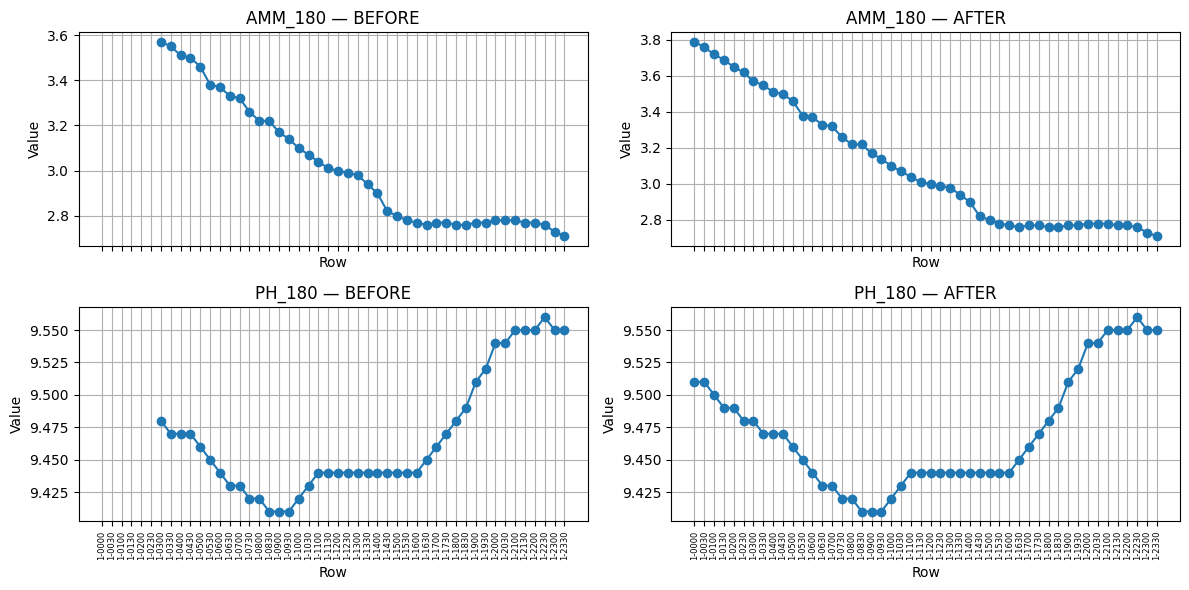

In [ ]:
# BEFORE AND AFTER INTERPOLATION

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# AMM_180
axes[0,0].plot(amm_before.iloc[:48], marker="o");
axes[0,0].set_title("AMM_180 — BEFORE")
axes[0,1].plot(lagged["AMM_180"].iloc[:48], marker="o");
axes[0,1].set_title("AMM_180 — AFTER")

# PH_180
axes[1,0].plot(ph_before.iloc[:48], marker="o");
axes[1,0].set_title("PH_180 — BEFORE")
axes[1,1].plot(lagged["PH_180"].iloc[:48], marker="o");
axes[1,1].set_title("PH_180 — AFTER")

for ax in axes.flat:
    ax.set_xlabel("Row")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.tick_params(axis="x", rotation=90, labelsize=6)

plt.tight_layout()
plt.show()

##### Interpolation using method "time" is not suited for the lagged dataframe.

Reason: It uses the same/flat values to replace the NaN.

```
start_date = pd.Timestamp("2024-10-04")

idx = lagged.index.astype(str)                          # "DAY_HHMM"
day  = idx.str.split("-", n=1).str[0].astype(int)        # 1,2,...,160
hhmm = idx.str[-4:]                                      # "0000","0030",...

hours   = hhmm.str[:2].astype(int)
minutes = hhmm.str[2:].astype(int)

dt_index = (start_date
            + pd.to_timedelta(day - 1, unit="D")
            + pd.to_timedelta(hours,   unit="h")
            + pd.to_timedelta(minutes, unit="m"))

lagged_dt = lagged.copy()
lagged_dt.index = pd.DatetimeIndex(dt_index, name="timestamp")
```
```
lagged_dt_interp = lagged_dt.interpolate(method="time", limit_direction="both")
```
```
# recompute day number relative to 2024-10-04
day_num = (lagged_dt_interp.index.normalize() - start_date).days + 1
hhmm    = lagged_dt_interp.index.strftime("%H%M")
day_hhmm = day_num.astype(str) + "-" + hhmm

lagged_df = lagged_dt_interp.copy()
lagged_df.index = day_hhmm
lagged_df.index.name = "DAY_HHMM"
```

#### Correlation Analysis using .corr()

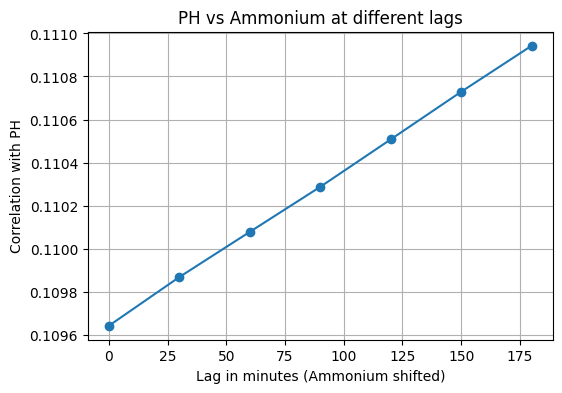

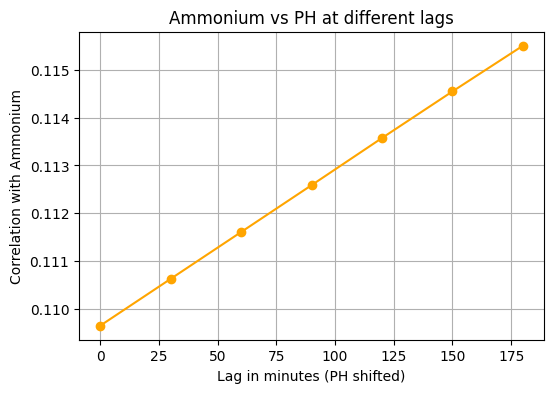

In [ ]:
lags = [0, 30, 60, 90, 120, 150, 180]

# --- Plot 1: PH vs Ammonium (lagged) ---
correlations_ph = []
for m in lags:
    col = "AMM" if m == 0 else f"AMM_{m}"
    correlations_ph.append(lagged["PH"].corr(lagged[col]))

plt.figure(figsize=(6,4))
plt.plot(lags, correlations_ph, marker="o")
plt.xlabel("Lag in minutes (Ammonium shifted)")
plt.ylabel("Correlation with PH")
plt.title("PH vs Ammonium at different lags")
plt.grid(True)
plt.show()


# --- Plot 2: Ammonium vs PH (lagged) ---
correlations_ammo = []
for m in lags:
    col = "PH" if m == 0 else f"PH_{m}"
    correlations_ammo.append(lagged["AMM"].corr(lagged[col]))

plt.figure(figsize=(6,4))
plt.plot(lags, correlations_ammo, marker="o", color="orange")
plt.xlabel("Lag in minutes (PH shifted)")
plt.ylabel("Correlation with Ammonium")
plt.title("Ammonium vs PH at different lags")
plt.grid(True)
plt.show()

Interpretation: The plots show that pH and Ammonium have only a weak correlation (~0.11), with no clear lead–lag relationship across the tested lags.

Suggestion: Use non-linear or time-series methods (e.g., cross-correlation or Spearman correlation) to check if hidden patterns exist beyond simple linear correlation.

#### Correlational Analysis using Pearson, Spearman, and Kendall Tu

Lagged Correlation Analysis (using scipy.stats):

--- Correlation between PH and AMM_30 ---
Pearson correlation coefficient: 0.1099
Pearson p-value: 0.0000
Spearman correlation coefficient: 0.0897
Spearman p-value: 0.0000
Kendall Tau correlation coefficient: 0.0999
Kendall Tau p-value: 0.0000

--- Correlation between PH and AMM_60 ---
Pearson correlation coefficient: 0.1101
Pearson p-value: 0.0000
Spearman correlation coefficient: 0.0897
Spearman p-value: 0.0000
Kendall Tau correlation coefficient: 0.0999
Kendall Tau p-value: 0.0000

--- Correlation between PH and AMM_90 ---
Pearson correlation coefficient: 0.1103
Pearson p-value: 0.0000
Spearman correlation coefficient: 0.0897
Spearman p-value: 0.0000
Kendall Tau correlation coefficient: 0.0999
Kendall Tau p-value: 0.0000

--- Correlation between PH and AMM_120 ---
Pearson correlation coefficient: 0.1105
Pearson p-value: 0.0000
Spearman correlation coefficient: 0.0897
Spearman p-value: 0.0000
Kendall Tau correlation coefficient: 0.100

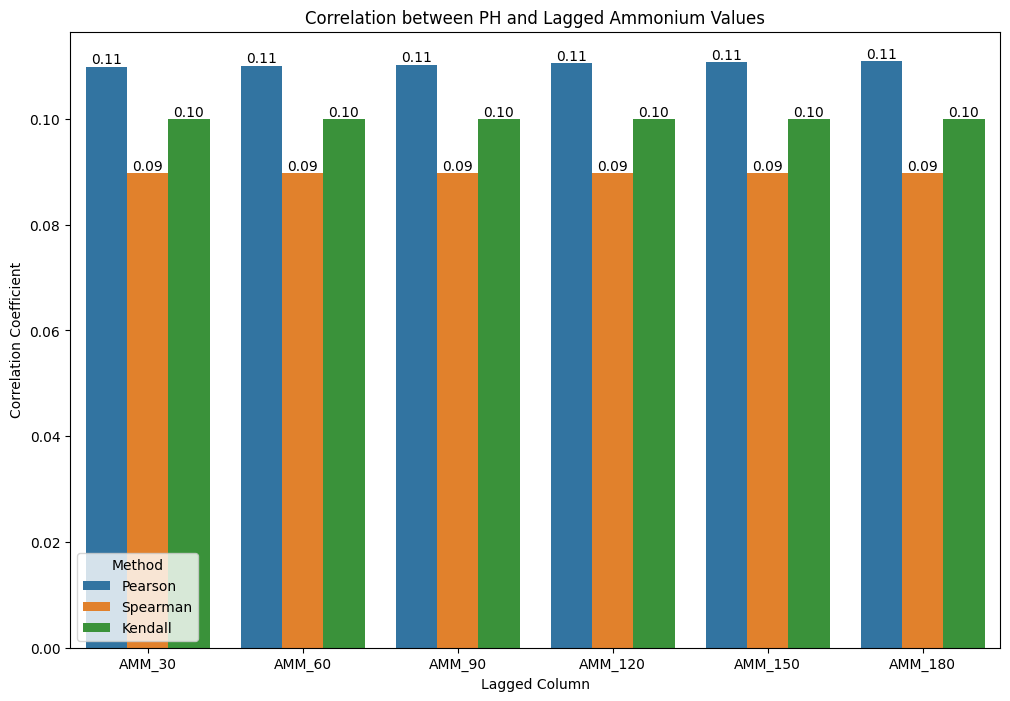

In [ ]:
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def lagged_correlation_analysis_for_ph(df):
    """
    Compute Pearson, Spearman, and Kendall correlations
    between PH and lagged AMMONIUM values using scipy.stats and visualize results.
    """
    ph_col = df['PH']
    lagged_ammo_cols = [col for col in df.columns if col.startswith('AMM_')]

    print("Lagged Correlation Analysis (using scipy.stats):")

    correlation_data = []

    for ammo_col in lagged_ammo_cols:
        # Pearson Correlation
        pearson_corr, pearson_p_value = pearsonr(ph_col, df[ammo_col])
        print(f"\n--- Correlation between PH and {ammo_col} ---")
        print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
        print(f"Pearson p-value: {pearson_p_value:.4f}")
        correlation_data.append({'Lagged Column': ammo_col, 'Method': 'Pearson', 'Correlation': pearson_corr})


        # Spearman Correlation
        spearman_corr, spearman_p_value = spearmanr(ph_col, df[ammo_col])
        print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
        print(f"Spearman p-value: {spearman_p_value:.4f}")
        correlation_data.append({'Lagged Column': ammo_col, 'Method': 'Spearman', 'Correlation': spearman_corr})


        # Kendall Tau Correlation
        kendall_corr, kendall_p_value = kendalltau(ph_col, df[ammo_col])
        print(f"Kendall Tau correlation coefficient: {kendall_corr:.4f}")
        print(f"Kendall Tau p-value: {kendall_p_value:.4f}")
        correlation_data.append({'Lagged Column': ammo_col, 'Method': 'Kendall', 'Correlation': kendall_corr})


    # Create a DataFrame for plotting
    correlation_df = pd.DataFrame(correlation_data)

    # Plotting the correlations as a bar graph
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Lagged Column', y='Correlation', hue='Method', data=correlation_df)
    plt.title('Correlation between PH and Lagged Ammonium Values')
    plt.ylabel('Correlation Coefficient')

    # Add numerical values on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

    plt.show()


# Example usage with your lagged dataframe:
lagged_correlation_analysis_for_ph(lagged)

**Explanation of Results:**
The analysis shows that Pearson, Spearman, and Kendall correlations between pH and lagged Ammonium values are all low (~0.09–0.11), with Pearson consistently slightly higher and increasing very slowly as the lag grows from 30 to 180 minutes. All p-values are 0.0000, meaning the correlations are statistically significant, but their effect size is still weak.

**Interpretation:**
pH and Ammonium have a weak but statistically consistent positive relationship, and small lags (30–180 minutes) do not significantly strengthen this correlation.

**Suggestion:**
Since linear correlations are weak, consider exploring non-linear models (e.g., polynomial regression, ARIMA with cross-correlation, or mutual information) to uncover deeper relationships between pH and Ammonium.

Lagged Correlation Analysis (Ammonium vs Lagged PH using scipy.stats):

--- Correlation between AMMONIUM and PH_30 ---
Pearson correlation coefficient: 0.1106
Pearson p-value: 0.0000
Spearman correlation coefficient: 0.0906
Spearman p-value: 0.0000
Kendall Tau correlation coefficient: 0.1005
Kendall Tau p-value: 0.0000

--- Correlation between AMMONIUM and PH_60 ---
Pearson correlation coefficient: 0.1116
Pearson p-value: 0.0000
Spearman correlation coefficient: 0.0914
Spearman p-value: 0.0000
Kendall Tau correlation coefficient: 0.1011
Kendall Tau p-value: 0.0000

--- Correlation between AMMONIUM and PH_90 ---
Pearson correlation coefficient: 0.1126
Pearson p-value: 0.0000
Spearman correlation coefficient: 0.0923
Spearman p-value: 0.0000
Kendall Tau correlation coefficient: 0.1018
Kendall Tau p-value: 0.0000

--- Correlation between AMMONIUM and PH_120 ---
Pearson correlation coefficient: 0.1136
Pearson p-value: 0.0000
Spearman correlation coefficient: 0.0932
Spearman p-value: 0.0000


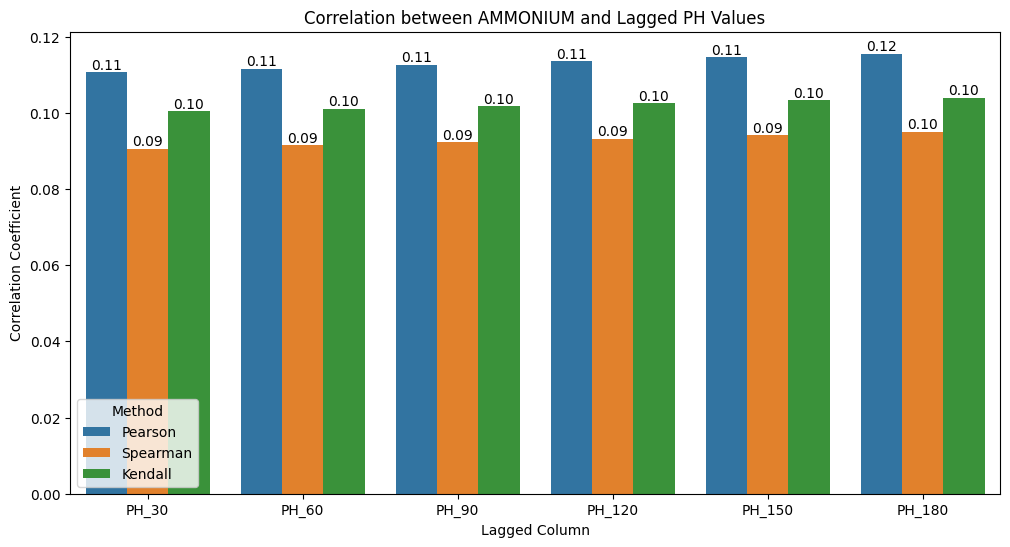

In [ ]:
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def lagged_correlation_analysis_for_ammonium(df):
    """
    Compute Pearson, Spearman, and Kendall correlations
    between AMMONIUM and lagged PH values using scipy.stats and visualize results.
    """
    ammo_col = df['AMM']
    lagged_ph_cols = [col for col in df.columns if col.startswith('PH_')]

    print("Lagged Correlation Analysis (Ammonium vs Lagged PH using scipy.stats):")

    correlation_data = []

    for ph_col in lagged_ph_cols:
        # Pearson Correlation
        pearson_corr, pearson_p_value = pearsonr(ammo_col.dropna(), df[ph_col].dropna())
        print(f"\n--- Correlation between AMMONIUM and {ph_col} ---")
        print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
        print(f"Pearson p-value: {pearson_p_value:.4f}")
        correlation_data.append({'Lagged Column': ph_col, 'Method': 'Pearson', 'Correlation': pearson_corr})


        # Spearman Correlation
        spearman_corr, spearman_p_value = spearmanr(ammo_col.dropna(), df[ph_col].dropna())
        print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
        print(f"Spearman p-value: {spearman_p_value:.4f}")
        correlation_data.append({'Lagged Column': ph_col, 'Method': 'Spearman', 'Correlation': spearman_corr})


        # Kendall Tau Correlation
        kendall_corr, kendall_p_value = kendalltau(ammo_col.dropna(), df[ph_col].dropna())
        print(f"Kendall Tau correlation coefficient: {kendall_corr:.4f}")
        print(f"Kendall Tau p-value: {kendall_p_value:.4f}")
        correlation_data.append({'Lagged Column': ph_col, 'Method': 'Kendall', 'Correlation': kendall_corr})


    # Create a DataFrame for plotting
    correlation_df = pd.DataFrame(correlation_data)

    # Plotting the correlations as a bar graph
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Lagged Column', y='Correlation', hue='Method', data=correlation_df)
    plt.title('Correlation between AMMONIUM and Lagged PH Values')
    plt.ylabel('Correlation Coefficient')

    # Add numerical values on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

    plt.show()

# Example usage with your lagged dataframe:
lagged_correlation_analysis_for_ammonium(lagged)

**Explanation of Results:**
The correlations (Pearson ≈ 0.11–0.12, Spearman ≈ 0.09–0.095, Kendall ≈ 0.10–0.104) are consistently weak but slightly stronger as lag increases from 30 to 180 minutes, with Pearson showing the largest incremental growth. All p-values are 0.0000, so the results are statistically significant but the effect size remains small.

**Interpretation:**
Ammonium and lagged pH show a weak but consistent positive correlation that increases slightly with longer lags, suggesting small temporal alignment between the two variables.

**Suggestion:**
To capture more meaningful dynamics, complement this linear correlation check with time-series methods like cross-correlation functions (CCF) or non-linear models to see if lagged pH changes explain Ammonium patterns more effectively.

#### Correlational Analysis using Linear Regression & Random Forest Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = lagged[["AMM","AMM_30", "AMM_60","AMM_90",
            "AMM_120","AMM_150","AMM_180"]]
y = lagged['PH']


model = LinearRegression()
model.fit(X, y)

print("Linear Regression Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print("\n")
print("Model Performance Metrics:")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Linear Regression Coefficients:
AMM: -0.3269
AMM_30: 0.0362
AMM_60: 0.0211
AMM_90: -0.0398
AMM_120: -0.0289
AMM_150: 0.0294
AMM_180: 0.3402


Model Performance Metrics:
R²: 0.0136
MSE: 0.0408
RMSE: 0.2019


**Explanation of Results:**
The linear regression coefficients vary in sign and magnitude, with AMM and AMM_180 showing the strongest opposing effects, while the other lagged terms contribute weakly; however, the overall model fit is very low (R² = 0.0136), meaning it explains only about 1.4% of the variance in pH.

**Interpretation:**
The regression suggests that individual lagged Ammonium values have limited predictive power for pH, and the relationship is weak and not well captured by a linear model.

**Suggestion:**
Consider exploring non-linear approaches (e.g., polynomial regression, time-series models, or machine learning) and feature engineering to better capture complex patterns between Ammonium and pH.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Features (X) = lagged ammonium values
X = lagged[["AMM", "AMM_30", "AMM_60", "AMM_90", "AMM_120", "AMM_150", "AMM_180"]]

# Target (y) = PH
y = lagged["PH"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200,      # number of trees
    max_depth=None,        # let trees expand fully
    random_state=42,
    n_jobs=-1              # use all CPU cores
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Model evaluation
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)



# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(importances)

print("\nRandom Forest Regression Results:")
print(f"R²:   {r2:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Feature Importances:
   Feature  Importance
6  AMM_180    0.306806
0      AMM    0.252792
5  AMM_150    0.111747
1   AMM_30    0.095290
4  AMM_120    0.090595
2   AMM_60    0.071760
3   AMM_90    0.071010

Random Forest Regression Results:
R²:   0.4519
MSE:  0.0238
RMSE: 0.1541


**Explanation of Results:**
The Random Forest model explains about 45% of the variance in pH (R² = 0.4519), with AMM_180 and AMM (current value) being the most influential predictors, followed by other lagged values with smaller contributions.

**Interpretation:**
Unlike linear regression, Random Forest captures non-linear patterns, showing that lagged Ammonium (especially AMM_180) plays a stronger role in predicting pH.

**Suggestion:**
Refine the model further by tuning hyperparameters (e.g., max_depth, min_samples_split) and testing additional features (like temperature, time of day, or moving averages) to see if prediction accuracy improves.

#### Refining the Random Forest Regressor using RandomzedSearchCV

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X = lagged[["AMM", "AMM_30", "AMM_60", "AMM_90","AMM_120", "AMM_150", "AMM_180"]]
y = lagged["PH"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid
param_dist = {
    "n_estimators": [100, 200, 500, 1000],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# creating a model for searching
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=30, cv=5, scoring="r2", random_state=42, n_jobs=-1
)

# searching for the best params for the rf model
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best R² (CV):", random_search.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}
Best R² (CV): 0.553908839487082


In [ ]:
# training the model with the best parameters
best_rf = random_search.best_estimator_

# predict the test data (features)
y_pred = best_rf.predict(X_test)

In [ ]:
# evaluation
mse =  mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")

importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importances": best_rf.feature_importances_
}).sort_values(by="Importances", ascending=False)

print(f"\n{importances_df}")


Model Performance Metrics:
R²: 0.561
MSE: 0.019
RMSE: 0.138

   Feature  Importances
6  AMM_180     0.173816
5  AMM_150     0.166885
4  AMM_120     0.147844
0      AMM     0.143103
3   AMM_90     0.128884
2   AMM_60     0.122051
1   AMM_30     0.117416


In [ ]:
# Using TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

X = lagged[["AMM", "AMM_30", "AMM_60", "AMM_90","AMM_120", "AMM_150", "AMM_180"]]
y = lagged["PH"]

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Define parameter grid
param_dist = {
    "n_estimators": [200, 500, 800, 1000],
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

tscv = TimeSeriesSplit(n_splits=5)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# creating a model for searching
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=50, cv=tscv, scoring="r2", random_state=42, n_jobs=-1, error_score="raise"
)

# searching for the best params for the rf model
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best R² (CV):", random_search.best_score_)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5}
Best R² (CV): -2.647434438218169


In [ ]:
# training the model with the best parameters
best_rf = random_search.best_estimator_

# predict the test data (features)
y_pred = best_rf.predict(X_test)

In [ ]:
# evaluation
mse =  mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")

importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importances": best_rf.feature_importances_
}).sort_values(by="Importances", ascending=False)

print(f"\n{importances_df}")


Model Performance Metrics:
R²: -1.102
MSE: 0.062
RMSE: 0.250

   Feature  Importances
4  AMM_120     0.167090
6  AMM_180     0.160256
3   AMM_90     0.154311
5  AMM_150     0.151633
1   AMM_30     0.143671
2   AMM_60     0.138524
0      AMM     0.084514


## DATA TRANSFORMATION 2 (WIDE FORMAT)

In [ ]:
format1 = format1.drop(columns=["INTERPOLATED"])

In [ ]:
format1

,PH VALUE (pH),AMMONIUM (mg/L)
DAY_HHMM,,
1-0000,9.48,3.57
1-0030,9.47,3.55
1-0100,9.47,3.51
1-0130,9.47,3.50
1-0200,9.46,3.46
...,...,...
160-2130,9.57,0.38
160-2200,9.59,0.38
160-2230,9.60,0.38


In [ ]:
def format2_reshaper(format1: pd.DataFrame, value_col=str) -> pd.DataFrame:
  tmp = pd.DataFrame({
      "DAY": format1.index.str.split("-", n=1).str[0].astype(int),
      "TIME": format1.index.str[-4:],
      value_col: format1[value_col].values
  })
  out = tmp.pivot(index="DAY", columns="TIME", values=value_col)
  return out.reindex(sorted(out.columns, key=int), axis=1)

In [ ]:
format2_ph = format2_reshaper(format1, "PH VALUE (pH)")
format2_ammo = format2_reshaper(format1, "AMMONIUM (mg/L)")
format2_both = pd.concat([format2_ph.add_prefix("ph_"),
                          format2_ammo.add_prefix("ammo_")], axis=1)

In [ ]:
format2_ammo

TIME,0000,0030,0100,0130,0200,0230,0300,0330,0400,0430,...,1900,1930,2000,2030,2100,2130,2200,2230,2300,2330
DAY,,,,,,,,,,,,,,,,,,,,,
1,3.57,3.55,3.51,3.50,3.46,3.38,3.37,3.33,3.32,3.26,...,2.77,2.76,2.73,2.71,2.68,2.67,2.64,2.63,2.62,2.61
2,2.50,2.49,2.48,2.50,2.51,2.52,2.52,2.53,2.54,2.52,...,2.49,2.48,2.45,2.45,2.43,2.42,2.40,2.40,2.42,2.40
3,2.41,2.41,2.41,2.41,2.40,2.40,2.40,2.40,2.40,2.40,...,2.41,2.40,2.40,2.40,2.40,2.40,2.40,2.39,2.39,2.38
4,2.36,2.36,2.36,2.36,2.36,2.36,2.36,2.36,2.36,2.36,...,2.37,2.37,2.37,2.37,2.36,2.36,2.36,2.36,2.36,2.36
5,2.33,2.34,2.34,2.34,2.34,2.34,2.34,2.34,2.34,2.34,...,2.45,2.44,2.44,2.45,2.45,2.44,2.44,2.44,2.44,2.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,0.42,0.42,0.42,0.42,0.42,0.42,0.42,0.42,0.42,0.42,...,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40
157,0.41,0.41,0.41,0.40,0.40,0.40,0.40,0.40,0.40,0.40,...,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39
158,0.39,0.38,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.38,...,0.33,0.32,0.32,0.32,0.32,0.31,0.31,0.31,0.31,0.30


In [ ]:
format2_both

TIME,ph_0000,ph_0030,ph_0100,ph_0130,ph_0200,ph_0230,ph_0300,ph_0330,ph_0400,ph_0430,...,ammo_1900,ammo_1930,ammo_2000,ammo_2030,ammo_2100,ammo_2130,ammo_2200,ammo_2230,ammo_2300,ammo_2330
DAY,,,,,,,,,,,,,,,,,,,,,
1,9.48,9.47,9.47,9.47,9.46,9.45,9.44,9.43,9.43,9.42,...,2.77,2.76,2.73,2.71,2.68,2.67,2.64,2.63,2.62,2.61
2,9.47,9.46,9.46,9.46,9.46,9.46,9.47,9.47,9.47,9.47,...,2.49,2.48,2.45,2.45,2.43,2.42,2.40,2.40,2.42,2.40
3,9.53,9.52,9.52,9.52,9.52,9.51,9.51,9.51,9.51,9.50,...,2.41,2.40,2.40,2.40,2.40,2.40,2.40,2.39,2.39,2.38
4,9.42,9.41,9.41,9.41,9.40,9.39,9.39,9.39,9.38,9.38,...,2.37,2.37,2.37,2.37,2.36,2.36,2.36,2.36,2.36,2.36
5,9.42,9.42,9.41,9.41,9.41,9.41,9.41,9.41,9.40,9.40,...,2.45,2.44,2.44,2.45,2.45,2.44,2.44,2.44,2.44,2.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,9.46,9.45,9.44,9.44,9.44,9.43,9.42,9.42,9.42,9.43,...,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40
157,9.44,9.44,9.44,9.44,9.44,9.43,9.43,9.42,9.41,9.41,...,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39
158,9.39,9.40,9.40,9.40,9.40,9.40,9.40,9.39,9.39,9.38,...,0.33,0.32,0.32,0.32,0.32,0.31,0.31,0.31,0.31,0.30


## PRINCIPAL COMPONENT ANALYSIS (PCA)

In [ ]:
from sklearn.preprocessing import StandardScaler

# PCA likes standardized features
scaled_format2 = StandardScaler().fit_transform(format2_both)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
scores = pca.fit_transform(scaled_format2)

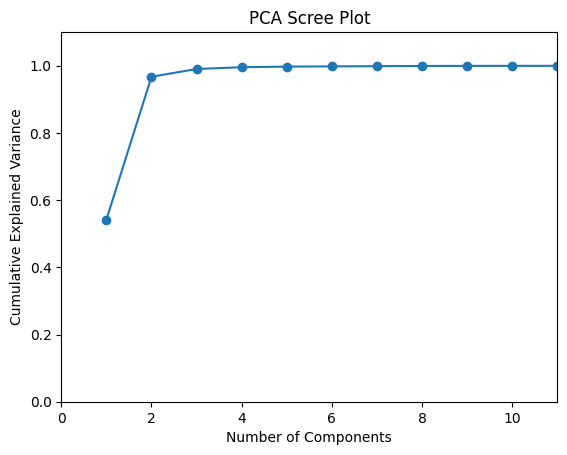

In [ ]:
import matplotlib.pyplot as plt

explained = pca.explained_variance_ratio_

plt.plot(range(1, len(explained) + 1), explained.cumsum(), marker="o")
plt.xlim(0, 11)
plt.ylim(0, 1.1)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.show()

In [ ]:
for i, var in enumerate(pca.explained_variance_ratio_[:5], start=1):
    print(f"PC{i}: {var:.2%}")
print("PC1+PC2:", f"{pca.explained_variance_ratio_[:2].sum():.2%}")

PC1: 54.18%
PC2: 42.53%
PC3: 2.32%
PC4: 0.53%
PC5: 0.17%
PC1+PC2: 96.71%


At PC1, the line jumps up very high, at 53.71%. At PC2, the line is already at 96.21%. The first 2–3 principal components are already enough to capture the important structure in the data.

In [ ]:
loadings = pd.DataFrame(
    pca.components_,
    columns=format2_both.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print(loadings.head())  # first few PCs

TIME   ph_0000   ph_0030   ph_0100   ph_0130   ph_0200   ph_0230   ph_0300  \
PC1   0.077997  0.078448  0.078376  0.078760  0.078798  0.079963  0.080613   
PC2   0.119655  0.119725  0.119919  0.120047  0.120096  0.119622  0.119419   
PC3  -0.186083 -0.184436 -0.185388 -0.181380 -0.181968 -0.178636 -0.175939   
PC4  -0.150930 -0.146419 -0.142030 -0.139297 -0.135989 -0.133622 -0.123474   
PC5   0.093595  0.091267  0.090385  0.088587  0.084758  0.080296  0.070625   

TIME   ph_0330   ph_0400   ph_0430  ...  ammo_1900  ammo_1930  ammo_2000  \
PC1   0.080981  0.081415  0.081481  ...   0.115814   0.115788   0.115743   
PC2   0.119235  0.119244  0.119311  ...  -0.085883  -0.085916  -0.085958   
PC3  -0.174841 -0.170887 -0.170060  ...  -0.000645   0.000184   0.000180   
PC4  -0.119695 -0.112465 -0.105279  ...  -0.008134  -0.008612  -0.009090   
PC5   0.071830  0.060397  0.051497  ...  -0.001378  -0.002692  -0.002900   

TIME  ammo_2030  ammo_2100  ammo_2130  ammo_2200  ammo_2230  ammo_2300  \


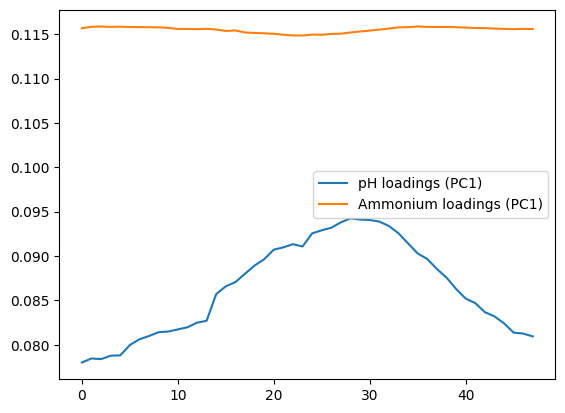

In [ ]:
loadings_pc1_ph   = loadings.loc["PC1", loadings.columns.str.startswith("ph_")]
loadings_pc1_ammo = loadings.loc["PC1", loadings.columns.str.startswith("ammo_")]

plt.plot(loadings_pc1_ph.values, label="pH loadings (PC1)")
plt.plot(loadings_pc1_ammo.values, label="Ammonium loadings (PC1)")
plt.legend()
plt.show()

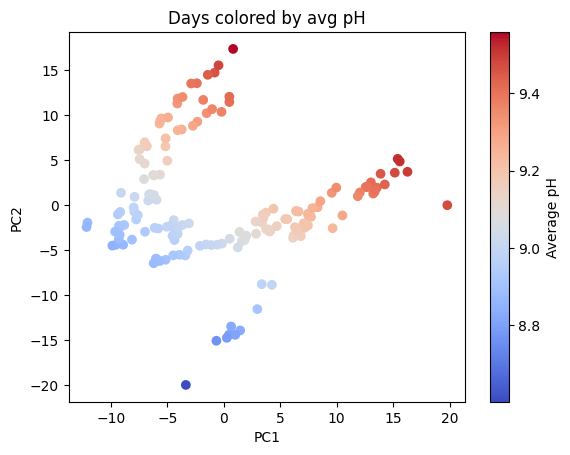

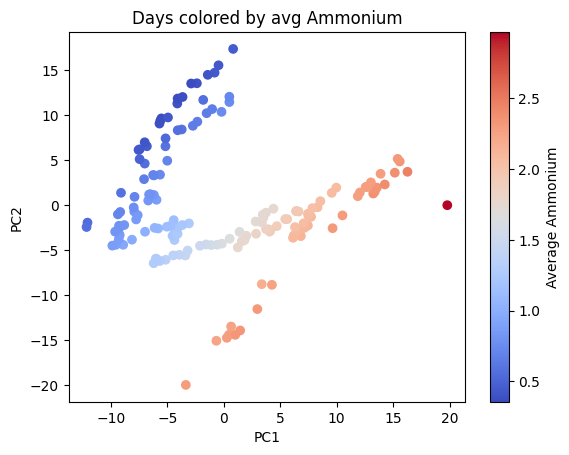

In [ ]:
import matplotlib.pyplot as plt

avg_ph   = format2_ph.mean(axis=1)      # average pH per day
avg_ammo = format2_ammo.mean(axis=1)    # average Ammonium per day

plt.scatter(scores[:,0], scores[:,1], c=avg_ph, cmap="coolwarm")
plt.colorbar(label="Average pH")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Days colored by avg pH"); plt.show()

plt.scatter(scores[:,0], scores[:,1], c=avg_ammo, cmap="coolwarm")
plt.colorbar(label="Average Ammonium")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Days colored by avg Ammonium"); plt.show()

In [ ]:
# correlation between first component scores of pH vs Ammonium
corr = np.corrcoef(scores[:,0], scores[:,1])[0,1]
print("Correlation between PC1 and PC2 scores:", corr)

Correlation between PC1 and PC2 scores: -1.201474803054303e-16


Interpretation: PCA shows that pH varies more strongly across the day, while ammonium stays relatively steady but still contributes to separating days. The scatter plots and color maps reveal that days with higher pH often align with lower ammonium and vice versa, highlighting their relationship. Overall, PCA confirms that pH and ammonium together explain most of the variation in the data and helps spot days that behave very differently from the rest.

#### Trying to detect the unusual days using PCA

In [ ]:
pcs = pca.transform(scaled_format2)

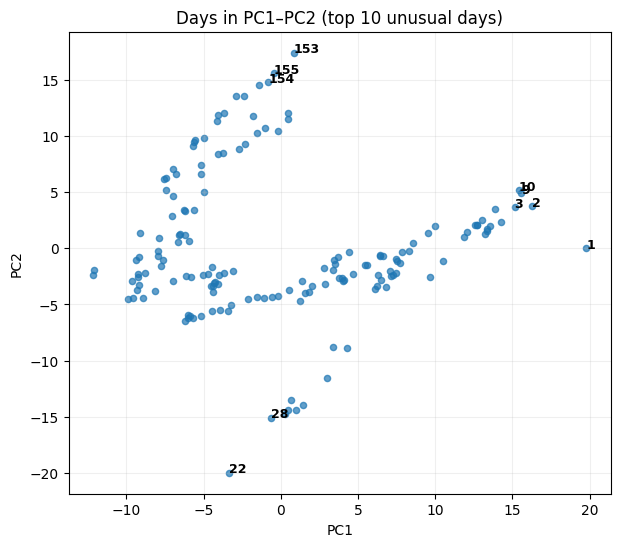

In [ ]:
days = getattr(format2_both.index, "tolist", lambda: list(range(1, len(pcs)+1)))()

# distance from origin using first 2 PCs
dist = np.sqrt(pcs[:, 0]**2 + pcs[:, 1]**2)
topk_idx = np.argsort(dist)[-10:]  # pick 10 most distant points

plt.figure(figsize=(7,6))
plt.scatter(pcs[:, 0], pcs[:, 1], s=20, alpha=0.7)

# label only the top 10
for i in topk_idx:
    plt.text(pcs[i, 0], pcs[i, 1], str(days[i]), fontsize=9, weight="bold")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Days in PC1–PC2 (top 10 unusual days)")
plt.grid(alpha=0.2)
plt.show()


In [ ]:
unusual_days = [1, 2, 3, 9, 10, 22, 28, 153, 154, 155]
df_unusual = format1[day_num.isin(unusual_days)]

In [ ]:
daily_means = format1.groupby(day_num)[["PH VALUE (pH)", "AMMONIUM (mg/L)"]].mean()

print(daily_means.loc[unusual_days])


          PH VALUE (pH)  AMMONIUM (mg/L)
DAY_HHMM                                
1              9.475625         2.968542
2              9.499792         2.465208
3              9.478542         2.385000
9              9.514583         2.341667
10             9.518125         2.310625
22             8.601667         2.305000
28             8.765208         2.239375
153            9.558542         0.449375
154            9.460208         0.447292
155            9.484167         0.427292


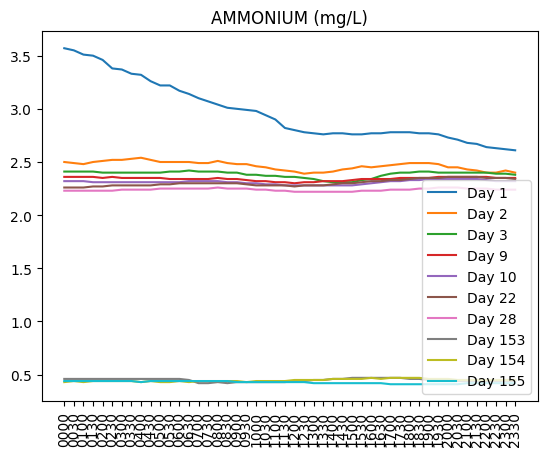

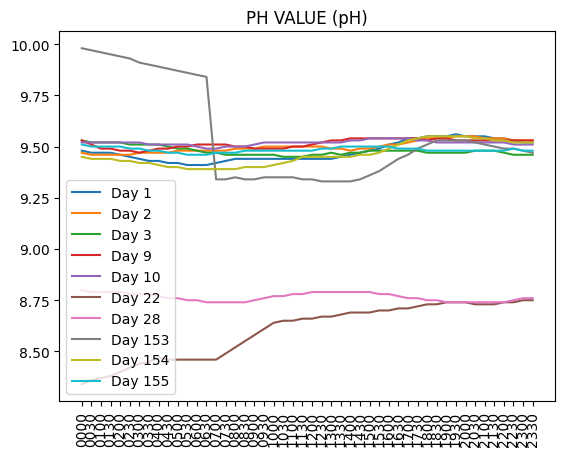

In [ ]:
def plot_day_comparison(day_list, col):
    for d in day_list:
        mask = day_num == d
        plt.plot(str_time[mask], format1.loc[mask, col], label=f"Day {d}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(col)
    plt.show()

plot_day_comparison([1, 2, 3, 9, 10, 22, 28, 153, 154, 155], "AMMONIUM (mg/L)")
plot_day_comparison([1, 2, 3, 9, 10, 22, 28, 153, 154, 155], "PH VALUE (pH)")

#### Another PCA Code:


```
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def run_pca_with_scree(df, n_components):
    """
    Run PCA on stacked PH & Ammonium dataframe.
    Rows = days, Columns = 30-min PH & Ammonium features.

    Returns:
        pca: fitted PCA object
        pcs_df: DataFrame of principal component scores
        loadings_df: DataFrame of principal component loadings
    """
    # Standardize (important for PCA since PH and Ammonium have different scales)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)

    # PCA
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled)
    pcs_df = pd.DataFrame(
        pcs,
        index=df.index,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )

    # Scree plot with values
    plt.figure(figsize=(8,5))
    explained_var = pca.explained_variance_ratio_

    plt.plot(range(1, n_components+1), explained_var, "o-", linewidth=2)
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    plt.title(f"Scree Plot of the transformed dataframe (format2)")
    plt.grid(True)

    # Annotate each point with its explained variance value
    for i, val in enumerate(explained_var, start=1):
        plt.text(i, val, f"{val:.2f}", ha="center", va="bottom", fontsize=9)

    plt.show()

    # Calculate loadings
    loadings_df = pd.DataFrame(
        pca.components_.T,
        index=df.columns,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )


    return pca, pcs_df, loadings_df

# Example usage:
# pca, pcs_df = run_pca_with_scree(stacked_df, n_components=10)
```


```
pca, pcs_df, loadings_df = run_pca_with_scree(format1, n_components=2)

print("Loadings (feature contributions):")
print(loadings_df)

print("\nFirst few PCA scores:")
print(pcs_df.head())
```

```
import numpy as np
import matplotlib.pyplot as plt

def pca_biplot(pcs_df, loadings, scale_fraction=0.8, annotate_offset=1.15):
    """
    Biplot for PC1 vs PC2 with feature loadings as arrows.
    - pcs_df: DataFrame with columns 'PC1' and 'PC2' (rows = observations)
    - loadings: DataFrame (index = feature names) with 2 columns [PC1, PC2] (component weights)
    - scale_fraction: fraction of the data spread used to scale arrow lengths
    """
    # basic checks
    for col in ("PC1", "PC2"):
        if col not in pcs_df.columns:
            raise ValueError(f"pcs_df must contain column '{col}'")
    if loadings.shape[1] < 2:
        raise ValueError("loadings must have at least two columns (PC1, PC2)")

    # numeric arrays
    pc1 = pcs_df["PC1"].values
    pc2 = pcs_df["PC2"].values

    # determine data-based scale for arrows (use numpy explicitly to avoid shadowing issues)
    data_max = np.max(np.abs(np.concatenate([pc1, pc2])))
    if data_max == 0:
        data_max = 1.0
    arrow_scale = data_max * float(scale_fraction)

    plt.figure(figsize=(11,9))
    plt.scatter(pc1, pc2, alpha=0.6, s=30)
    plt.xlabel("PC1 (56%)")
    plt.ylabel("PC2 (44%)")
    plt.title("PCA biplot (PC1 vs PC2) using format2")

    # draw arrows for each feature (use iloc to access loadings)
    for i, feat in enumerate(loadings.index):
        vx = loadings.iloc[i, 0] * arrow_scale   # PC1 loading * scale
        vy = loadings.iloc[i, 1] * arrow_scale   # PC2 loading * scale

        # arrow properties scale with arrow_scale so they're visible
        plt.arrow(0, 0, vx, vy,
                  color="red",
                  width=arrow_scale * 0.002,
                  head_width=arrow_scale * 0.04,
                  length_includes_head=True,
                  alpha=0.9)

        plt.text(vx * annotate_offset, vy * annotate_offset, feat,
                 color="red", ha="center", va="center", fontsize=10)

    plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    return pcs_df


pca_biplot(pcs_df, loadings_df)
```
